In [1]:
import sys
sys.path.insert(0, '/Users/abrahamn/21cmIR/21cmIRxcor/')
import mwa_utils

In [2]:
import pickle
import numpy as np
from numpy import pi
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# MWA uv space sampling
analysis_root = '/Volumes/abraham/xcor_data/analysis/21cmfreqavgcubes/'
fhddeeplabel = 'Combined_obs_wedge_cut_plus_res_cut'
mwa_deep_image = pickle.load( open( analysis_root+fhddeeplabel+'.p', "rb" ) )

In [4]:
# cosmology
from cosmocalc import cosmocalc
WM,WV = 0.27,0.73
c = 3.e8
h = 6.626e-34 # J*sec
c_over_H0_Mpc = 4283.

# rest frame freqs
lamda0_IR_m = 120.e-9
f0_21_Hz = 1420.e6

In [5]:
# perp sampling
theta_fov_rad = mwa_deep_image.n*mwa_deep_image.dtheta_rad
dtheta_rad = mwa_deep_image.dtheta_rad
Nperp = mwa_deep_image.n

In [6]:
# the total obs time in each uv cell is proportional to weights_uv
weights_uv = np.abs(np.fft.fft2(mwa_deep_image.weights_xx0))

# t_hours = 100.
# #t_hours = 500.
# t_obs_21_sec = t_hours*3600.

Nant = 112 # 128 MWA ants minus 16 outriggers
# num_baselines = Nant*(Nant-1)/2
# num_seconds_per_uv = weights_uv/np.sum(weights_uv)*np.sum(num_baselines*t_obs_21_sec)

lamda = 300./185
# du = 1./(mwa_deep_image.n*mwa_deep_image.dtheta_rad)
# umax = du*mwa_deep_image.n/2

# plt.imshow(np.log10(np.fft.fftshift(num_seconds_per_uv)),interpolation='nearest',vmin=0,vmax=5.5,extent=[-umax,umax,-umax,umax])
# plt.colorbar()

In [44]:
# 21cm thermal noise
# https://www.evernote.com/shard/s316/nl/2147483647/6f7c9ac4-f872-407d-89e3-acb8fdff1982/

def calc_P_21_thermal_veck(t_int_mwa_hours,D,DeltaD,B_21_Hz,Nf,z):
    num_baselines = Nant*(Nant-1)/2
    num_seconds_per_uv = weights_uv/np.sum(weights_uv)*np.sum(num_baselines*t_int_mwa_hours*3600)
    
    Tsky_K = 200.
    A_21 = 20. # m^2
    lamda = .21*(1+z)
    P_21_thermal = (Tsky_K**2)*(lamda**2)*(D**2)*DeltaD/(B_21_Hz*A_21)/num_seconds_per_uv
    return np.repeat([P_21_thermal],Nf,axis=0)

In [45]:
# IR shot noise
# https://www.evernote.com/shard/s316/nl/2147483647/89eb8fb1-82bf-46c2-a07a-4c81d1fd171b/
# https://www.evernote.com/shard/s316/nl/2147483647/0b490f35-5419-452a-9350-371cc062850b/

def calc_P_IR_shot_veck(t_int_ir_hours,D,DeltaD,B_IR_Hz,Nf,z):
    kjy = 1000 * 1.e-26
    Isky = 1.e3 # kJy/sr, space
    hf = h*c/(lamda0_IR_m*(1+z))
    A_IR = .5**2 # m^2
    P_IR_shot = D**2*DeltaD*hf*Isky/(B_IR_Hz*3600*t_int_ir_hours*A_IR*kjy)

    return np.tile(P_IR_shot,(Nf,Nperp,Nperp))

In [46]:
def bin_noise_to_1D(P1_veck,P2_veck,nbins,kmax,kmaggrid,inwindow):
    kbinedges = np.linspace(0,kmax,nbins+1)
    dk = kbinedges[1]-kbinedges[0]
    kbincenters = .5*(kbinedges[0:nbins]+kbinedges[1:nbins+1])

    P_binned = np.zeros(nbins)
    P_binned_wedgecut = np.zeros(nbins)
    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (kmaggrid>kbinedges[bini])&(kmaggrid<kbinedges[bini+1])
        if inwindow is not None: inbin &= inwindow
    
        bin_counts[bini] = np.sum(inbin)
        P_binned[bini] = np.sqrt(1./(np.sum( 1./(P1_veck[inbin]*P2_veck[inbin]) )))
        
    return kbinedges,kbincenters,P_binned,bin_counts

In [47]:
# load Gong theoretical values
gongdat = np.genfromtxt('models/Gong14/gong_lyalpha_model_pspec_upperlimit_z=7.csv',delimiter=',',skip_header=3)
gong_k_upper = gongdat[:,0]
gong_Delta_kjy_per_sr_upperlimit = np.sqrt(gongdat[:,1])*1.e-3  # taking the square root, then multiplying by 1.e-3 
                                                      # converts from (Jy/sr)^2 to (kJy/sr)
gongdat = np.genfromtxt('models/Gong14/gong_lyalpha_model_pspec_lowerlimit_z=7.csv',delimiter=',',skip_header=3)
gong_k_lower = gongdat[:,0]
gong_Delta_kjy_per_sr_lowerlimit = np.sqrt(gongdat[:,1])*1.e-3

In [48]:
# load vanilla 21cmFAST power spectrum from Pober 14 (what can 21cm observatories teach us about reionization?)
poberdat = np.genfromtxt('models/Pober14/P21_Delta^2_mK^2_late_reionization.csv',delimiter=',',skip_header=3)
pober_k_upperlimit = poberdat[:,0]
pober_Delta_K_upperlimit = np.sqrt(poberdat[:,1])*1.e-3 # taking the square root and multiplying by 1.e-3 
                                                      # converts from mK^2 to K
    
poberdat = np.genfromtxt('models/Pober14/P21_Delta^2_mK^2_fiducial.csv',delimiter=',',skip_header=3)
pober_k_lowerlimit = poberdat[:,0]
pober_Delta_K_lowerlimit = np.sqrt(poberdat[:,1])*1.e-3

In [49]:
# let's interpolate all these models onto the the same k values
model_k = pober_k_lowerlimit
pober_Delta_K_lowerlimit_model_k = pober_Delta_K_lowerlimit

pober_Delta_K_upperlimit_model_k = np.interp(model_k,pober_k_upperlimit,pober_Delta_K_upperlimit)
gong_Delta_kjy_per_sr_upperlimit_model_k = np.interp(model_k,gong_k_upper,gong_Delta_kjy_per_sr_upperlimit)
gong_Delta_kjy_per_sr_lowerlimit_model_k = np.interp(model_k,gong_k_lower,gong_Delta_kjy_per_sr_lowerlimit)

In [50]:
def loglogbar(binedges,binyvals,bin_counts,col,label,lw):
    binedges[binedges==0] = 1.e-6
    binyvals[np.isinf(binyvals)] = 1.e-10
    
    plt.loglog([binedges[0],binedges[0]],[1.e-6,binyvals[0]],col,label=label,linewidth=lw)
    for bini in range(len(binyvals)):
        nextbinval = binyvals[bini+1] if bini+1 < len(binyvals) else 1.e-10
        plt.loglog([binedges[bini],binedges[bini+1],binedges[bini+1]],[binyvals[bini],binyvals[bini],nextbinval],col,linewidth=lw)

In [51]:
# matplotlib.rcParams.update({'font.size': 16})

# nbins = 5
# kmax = .9*np.max(kmaggrid)

# # cross spectra
# kbinedges,kbincenters,P_binned,bin_counts = bin_noise_to_1D(P_IR_shot_veck,P_21_thermal_veck,nbins,kmax,wedgecut=False)
# kbinedges,kbincenters,P_binned_wedgecut,bin_counts_wedgecut = bin_noise_to_1D(P_IR_shot_veck,P_21_thermal_veck,nbins,kmax,wedgecut=True)

# # auto spectra
# kbinedges,kbincenters,P_21_binned,bin_counts = bin_noise_to_1D(P_21_thermal_veck,P_21_thermal_veck,nbins,kmax,wedgecut=False)
# kbinedges,kbincenters,P_IR_binned,bin_counts = bin_noise_to_1D(P_IR_shot_veck,P_IR_shot_veck,nbins,kmax,wedgecut=False)
# kbinedges,kbincenters,P_21_binned_wedgecut,bin_counts = bin_noise_to_1D(P_21_thermal_veck,P_21_thermal_veck,nbins,kmax,wedgecut=True)
# kbinedges,kbincenters,P_IR_binned_wedgecut,bin_counts = bin_noise_to_1D(P_IR_shot_veck,P_IR_shot_veck,nbins,kmax,wedgecut=True)


# plt.figure(figsize=(15,5))

# plt.subplot(131)
# loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_binned,bin_counts,'b',label='all bins',lw=3)
# loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_binned_wedgecut,bin_counts,'r',label='wedge cut',lw=2)
# plt.loglog(model_k,pober_Delta_K_upperlimit_model_k*gong_Delta_kjy_per_sr_upperlimit_model_k,'k-',label='opt. 21cm/IR model')
# plt.loglog(model_k,pober_Delta_K_lowerlimit_model_k*gong_Delta_kjy_per_sr_lowerlimit_model_k,'m-',label='pess. 21cm/IR model')

# plt.xlabel('k (Mpc$^-1$)')
# plt.ylabel(r'$\Delta^2$ (K$\cdot$kJy/sr)')
# plt.xlim([.03,1])
# plt.ylim([1.e-9,1.e-3])
# plt.title('21cm/IR Sensitivity (Thermal/Shot)')
# plt.legend(fontsize=12,loc=4)

# plt.subplot(132)
# loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_21_binned,bin_counts,'b',label='all bins',lw=3)
# loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_21_binned_wedgecut,bin_counts,'r',label='wedge cut',lw=2)
# plt.loglog(model_k,pober_Delta_K_upperlimit_model_k**2,'k-',label='opt. 21cm model')
# plt.loglog(model_k,pober_Delta_K_lowerlimit_model_k**2,'m-',label='pess. 21cm model')
# plt.xlabel('k (1/Mpc)')
# plt.ylabel(r'$\Delta^2$ (K$^2$)')
# plt.title('21cm Sensitivity (Thermal)')
# plt.xlim([.03,1])
# plt.ylim([1.e-9,1.e-3])
# plt.legend(fontsize=12,loc=4)

# plt.subplot(133)
# loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_IR_binned,bin_counts,'b',label='all bins',lw=3)
# loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_IR_binned_wedgecut,bin_counts,'r',label='wedge cut',lw=2)
# plt.loglog(model_k,gong_Delta_kjy_per_sr_upperlimit_model_k**2,'k-',label='opt. IR model')
# plt.loglog(model_k,gong_Delta_kjy_per_sr_lowerlimit_model_k**2,'m-',label='pess. IR model')
# plt.title('IR Sensitivity (Shot noise)')
# plt.xlabel('k (1/Mpc)')
# plt.ylabel(r'$\Delta^2$ (kJy/sr)$^2$')
# plt.xlim([.03,1])
# plt.ylim([1.e-8,1.e-2])
# plt.legend(fontsize=12,loc=4)

# plt.tight_layout()
# plt.savefig('cross_and_auto_sensitivity_case_study.pdf',bbox_inches='tight')

In [79]:
def p(nrows,ncols, Deltaz,R,t_int_mwa_hours,t_int_ir_hours):
    
    # cosmology
    z = 7.
    Ez = np.sqrt(WM*(1+z)**3+WV)
    D = cosmocalc(z,WM=WM,WV=WV)['DCMR_Mpc']
    DeltaD = c_over_H0_Mpc*Deltaz/Ez
    wedgeslope = D*Ez/(c_over_H0_Mpc*(1+z))*(pi/2)
    
    # frequencies and redshifts
    dz = (1+z)/R
    Nf = int(Deltaz / dz)
    B_IR_Hz = Deltaz*c/lamda0_IR_m/(1+z)**2
    B_21_Hz = Deltaz*f0_21_Hz/(1+z)**2
    
    # survey geometry
    dkpara = 2.*pi/DeltaD
    kparamax = Nf/2*dkpara
    dkperp = 2.*pi/(theta_fov_rad*D)
    kperpmax = Nperp/2*dkperp
    kparavals = np.fft.fftfreq(Nf)*Nf*dkpara
    kperpvals = np.fft.fftfreq(Nperp)*Nperp*dkperp
    kzgrid,kxgrid,kygrid = np.meshgrid(kparavals,kperpvals,kperpvals,indexing='ij')
    kperpgrid = np.sqrt(kxgrid**2+kygrid**2)
    kmaggrid = np.sqrt(kxgrid**2+kygrid**2+kzgrid**2)
    inwindow = kzgrid > wedgeslope*kperpgrid

    # calculate thermal and shot noise 3D power spectra (over \vec{k} cube)
    P_21_thermal_veck = calc_P_21_thermal_veck(t_int_mwa_hours,D,DeltaD,B_21_Hz,Nf,z)
    P_IR_shot_veck = calc_P_IR_shot_veck(t_int_ir_hours,D,DeltaD,B_IR_Hz,Nf,z)
    
    # cross and auto spectra
    nbins,kmax = 5,.9*np.max(kmaggrid)
    
    kbinedges,kbincenters,P_binned,bin_counts = bin_noise_to_1D(P_IR_shot_veck,P_21_thermal_veck,nbins,kmax,kmaggrid,inwindow=None)
    kbinedges,kbincenters,P_binned_wedgecut,bin_counts_wedgecut = bin_noise_to_1D(P_IR_shot_veck,P_21_thermal_veck,nbins,kmax,kmaggrid,inwindow)
      
    kbinedges,kbincenters,P_21_binned,bin_counts = bin_noise_to_1D(P_21_thermal_veck,P_21_thermal_veck,nbins,kmax,kmaggrid,inwindow=None)
    kbinedges,kbincenters,P_IR_binned,bin_counts = bin_noise_to_1D(P_IR_shot_veck,P_IR_shot_veck,nbins,kmax,kmaggrid,inwindow=None)
      
    kbinedges,kbincenters,P_21_binned_wedgecut,bin_counts = bin_noise_to_1D(P_21_thermal_veck,P_21_thermal_veck,nbins,kmax,kmaggrid,inwindow)
    kbinedges,kbincenters,P_IR_binned_wedgecut,bin_counts = bin_noise_to_1D(P_IR_shot_veck,P_IR_shot_veck,nbins,kmax,kmaggrid,inwindow)


    # make sensitivity plots
    global currplotindex
    atbottom = currplotindex > nrows*ncols-ncols
    attop = currplotindex <= ncols
    plt.subplot(nrows,ncols,currplotindex)
    
    loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_binned,bin_counts,'b',label='all bins',lw=3)
    loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_binned_wedgecut,bin_counts,'r',label='wedge cut',lw=2)
    plt.loglog(model_k,pober_Delta_K_upperlimit_model_k*gong_Delta_kjy_per_sr_upperlimit_model_k,'k-',label='opt. 21cm/IR model')
    plt.loglog(model_k,pober_Delta_K_lowerlimit_model_k*gong_Delta_kjy_per_sr_lowerlimit_model_k,'m-',label='pess. 21cm/IR model')
    if atbottom: plt.xlabel('k (Mpc$^-1$)')
    else: plt.gca().xaxis.set_ticklabels([])
    plt.ylabel(r'$\Delta^2$ (K$\cdot$kJy/sr)')
    plt.xlim([.03,1])
    plt.ylim([1.e-9,1.e-3])
    title_prefix = '21cm/IR Sensitivity (Thermal/Shot)\n\n' if attop else ''
    plt.title(title_prefix+"$\Delta$z=%1.1f, R=%d"%(Deltaz,R))
    if attop: plt.legend(fontsize=12,loc=4)

    plt.subplot(nrows,ncols,currplotindex+1)
    loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_21_binned,bin_counts,'b',label='all bins',lw=3)
    loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_21_binned_wedgecut,bin_counts,'r',label='wedge cut',lw=2)
    plt.loglog(model_k,pober_Delta_K_upperlimit_model_k**2,'k-',label='opt. 21cm model')
    plt.loglog(model_k,pober_Delta_K_lowerlimit_model_k**2,'m-',label='pess. 21cm model')
    if atbottom: plt.xlabel('k (1/Mpc)')
    else: plt.gca().xaxis.set_ticklabels([])
    #plt.ylabel(r'$\Delta^2$ (K$^2$)')
    plt.gca().yaxis.set_ticklabels([])
    if attop: plt.title('21 Sensitivity (Thermal)\n\n')
    plt.xlim([.03,1])
    plt.ylim([1.e-9,1.e-3])
    if attop: plt.legend(fontsize=12,loc=4)

    plt.subplot(nrows,ncols,currplotindex+2)
    loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_IR_binned,bin_counts,'b',label='all bins',lw=3)
    loglogbar(kbinedges,kbincenters**3/(2*pi**2)*P_IR_binned_wedgecut,bin_counts,'r',label='wedge cut',lw=2)
    plt.loglog(model_k,gong_Delta_kjy_per_sr_upperlimit_model_k**2,'k-',label='opt. IR model')
    plt.loglog(model_k,gong_Delta_kjy_per_sr_lowerlimit_model_k**2,'m-',label='pess. IR model')
    if attop: plt.title('IR Sensitivity (Shot noise)\n\n')
    if atbottom: plt.xlabel('k (1/Mpc)')
    else: plt.gca().xaxis.set_ticklabels([])
    #plt.ylabel(r'$\Delta^2$ (kJy/sr)$^2$')
    plt.gca().yaxis.set_ticklabels([])
    plt.xlim([.03,1])
    plt.ylim([1.e-8,1.e-2])
    if attop: plt.legend(fontsize=12,loc=4)
    
    currplotindex += 3

/Users/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars


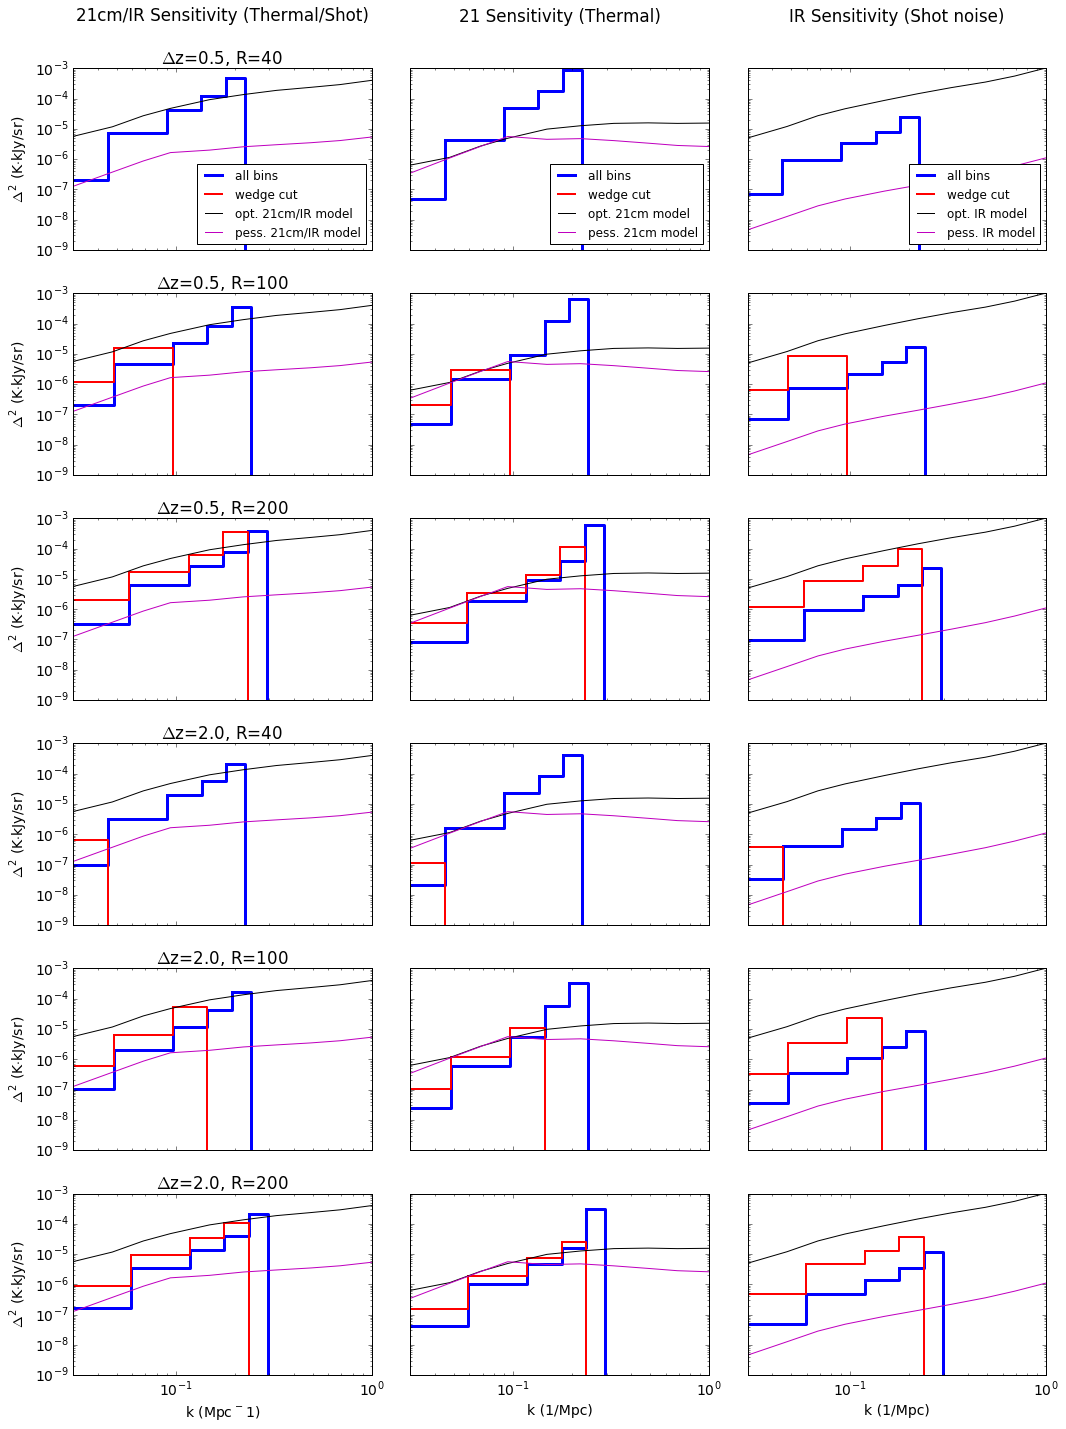

In [80]:
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.figure(figsize=(15,20))

nrows,ncols = 6,3
currplotindex = 1

p(nrows,ncols, Deltaz=0.5, R=40, t_int_mwa_hours=100, t_int_ir_hours=.5)
p(nrows,ncols, Deltaz=0.5, R=100, t_int_mwa_hours=100, t_int_ir_hours=.5)
p(nrows,ncols, Deltaz=0.5, R=200, t_int_mwa_hours=100, t_int_ir_hours=.5)

p(nrows,ncols, Deltaz=2, R=40, t_int_mwa_hours=100, t_int_ir_hours=.5)
p(nrows,ncols, Deltaz=2, R=100, t_int_mwa_hours=100, t_int_ir_hours=.5)
p(nrows,ncols, Deltaz=2, R=200, t_int_mwa_hours=100, t_int_ir_hours=.5)

plt.tight_layout()
plt.savefig('cross_and_auto_sensitivity_grid.pdf',bbox_inches='tight')